# BTC Futures 에 내제되어있는 funding rate term structure 분석

선물 계약은 레버리지가 가능하다. 일정 증거금만 있으면 2배, 3배 많게는 100배 이상 레버리지를 키울 수 있다. 즉 내가 지금 비트코인 10개만큼 사는 포지션을 구축하고 싶은데 레버리지 10배 선물 롱 계약을 체결하면 비트코인 1개로 비트코인 10개만큼 보유하고 있는것과 비슷한 경제적인 효과를 얻을 수 있는 것이다. 투자자가 비트코인 10개를 사려면 비트코인 10개 가치만큼의 현금이 초기에 필요하지만 그만큼의 현금이 없다면 선물이라는 파생상품으로 그 문제를 해결할 수 있는 것이다. 물론 공짜 점심은 없기 때문에 지불해야할 비용이 있는데 바로 Funding Fee 또는 현,선물 basis이다.  \
 일반적인 장내선물 파생상품은 대부분 만기가 정해져 있다. 코인선물시장에서는 만기가 정해진 파생상품도 존재하지만, 거래량과 open interest 가 압도적으로 많은 파생상품은 perpetual 선물이다. BTC perpetual 선물은 만기가 없고 8시간마다(일반적으로) Funding Fee 만큼 정산을 하게 되는데 이걸 1년동안 누적하면 연율화 된 비용이 나오게 된다. 즉 펀딩피를 1년동안 모두 더하면 선물 롱 계약 매수자가 레버리지 1배를 증가시킬 때 마다 드는 비용이 나올 것이다.  \ 
 해외 코인 거래소에서 물론 만기가 있는 선물도 존재한다. 만기가 있는 선물은 가격에 내제되어있는 금리를 구할 수 있고 만기가 길게는 1년까지 존재한다.

 만기가 없는 선물, 만기가 있는 선물의 내제되어있는 금리를 분석하여 선물간 spread 거래를 하거나, 통계적으로 금리가 회귀하는 성질을 이용하여 통계적 차익거래 전략을 생각해 볼 수 있을 것이다.  \

코인 관련 파생상품은 deribit 거래소가 다양한 파생거래를 지원해 주기 때문에 해당 거래소 내에서만 분석을 먼저 해보자.(옵션상품 역시 다양한 행사가별, 만기별 상품이 존재)

In [31]:
from crypto import pyderibit, CONFIG
api = pyderibit.Deribit(CONFIG.DERIBIT['MAIN_URL'])

In [32]:
dict_fut = api.get_instruments_all_list('BTC','2018-01-01')

In [33]:
import datetime
currency = 'BTC'
end_time = datetime.datetime.now()
start_time = end_time - datetime.timedelta(days=3000)
df_all_data = api.get_historical_futures_price(currency+'-'+'PERPETUAL', start_time, end_time)[['ticks','close']]

In [34]:
import pandas as pd
for symbol, item in dict_fut.items():
    df_k_price = api.get_historical_futures_price(symbol, start_time, end_time)
    df_k_price = df_k_price[((df_k_price.ticks >= item['creation_timestamp']) & (df_k_price.ticks <item['expiration_timestamp']))]
    df_k_price = df_k_price[['ticks','close']]
    df_all_data = pd.merge(df_all_data,df_k_price,on = 'ticks', how='left', suffixes = ('','_'+symbol))

df_all_data['datetime'] = pd.to_datetime(df_all_data['ticks'], unit='ms')
df_all_data.set_index('datetime', inplace=True)

df_all_data.columns = [col.replace('close_', '') for col in df_all_data.columns]
df_all_data = df_all_data.drop(columns=['ticks','close'])
df_all_data = df_all_data.dropna(subset=[currency+'-PERPETUAL'])
df_all_data

,BTC-26JAN18,BTC-23FEB18,BTC-30MAR18,BTC-27APR18,BTC-25MAY18,BTC-29JUN18,BTC-27JUL18,BTC-31AUG18,BTC-28SEP18,BTC-28DEC18,...,BTC-19JUL24,BTC-26JUL24,BTC-16AUG24,BTC-23AUG24,BTC-30AUG24,BTC-27SEP24,BTC-27DEC24,BTC-28MAR25,BTC-27JUN25,BTC-PERPETUAL
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-15 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6345.5,6347.5,6349.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6377.0
2018-08-16 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6452.5,6453.0,6456.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6490.0
2018-08-17 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6434.5,6435.0,6441.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6467.0
2018-08-18 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6315.0,6319.5,6320.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6351.0
2018-08-19 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6415.0,6413.5,6414.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6454.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-11 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,58710.0,58807.5,58855.0,59310.0,60970.0,62682.5,64275.0,58674.0
2024-08-12 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,59252.5,59335.0,59415.0,59800.0,61545.0,63212.5,64740.0,59256.5
2024-08-13 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,60955.0,61015.0,61117.5,61580.0,63260.0,65057.5,66810.0,60943.5


/var/folders/qc/1xrxdszx3m95xzknt3ptpq4c0000gn/T/ipykernel_11270/2723478528.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series_mty = pd.Series()


Annual futures 가 처음으로 등장하였을 때:  2021-04-20 08:00:00


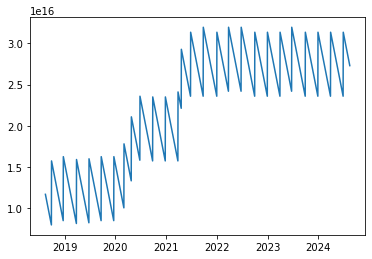

In [159]:
import numpy as np
series_mty = pd.Series()
for idx, row in df_all_data.iterrows():
    
    max_len = max(pd.to_datetime([dict_fut[i]['expiration_timestamp'] for i in row.dropna().drop('BTC-PERPETUAL').index],unit='ms') - idx)
    series_mty[idx] = max_len

plt.plot(series_mty)
start_1y = series_mty[series_mty >= datetime.timedelta(days=300)]
start_1y_index = start_1y.index[0]
print('Annual futures 가 처음으로 등장하였을 때: ',start_1y_index)

In [35]:
from models import termstruc
model = termstruc.InterestTermStructure('BTC', df_all_data, dict_fut)

In [81]:
ls_index = df_all_data.index
filtered_dates = ls_index[ls_index > pd.Timestamp('2020-01-01 08:00:00')]

DatetimeIndex(['2018-08-15 08:00:00', '2018-08-16 08:00:00',
               '2018-08-17 08:00:00', '2018-08-18 08:00:00',
               '2018-08-19 08:00:00', '2018-08-20 08:00:00',
               '2018-08-21 08:00:00', '2018-08-22 08:00:00',
               '2018-08-23 08:00:00', '2018-08-24 08:00:00',
               ...
               '2024-08-06 08:00:00', '2024-08-07 08:00:00',
               '2024-08-08 08:00:00', '2024-08-09 08:00:00',
               '2024-08-10 08:00:00', '2024-08-11 08:00:00',
               '2024-08-12 08:00:00', '2024-08-13 08:00:00',
               '2024-08-14 08:00:00', '2024-08-15 08:00:00'],
              dtype='datetime64[ns]', name='datetime', length=2193, freq=None)

In [167]:
ls = {}
term = [30, 60, 120, 180, 240, 300, 360]
for i in df_all_data.loc[start_1y_index:].index:
    ls_term = []
    for j in term:
        ls_term.append(model.get_zrate(i, i + datetime.timedelta(days = j)))
    ls[i] = ls_term

In [168]:
df_termstructure = pd.DataFrame(ls)
df_termstructure = df_termstructure.transpose()
df_termstructure.columns = term

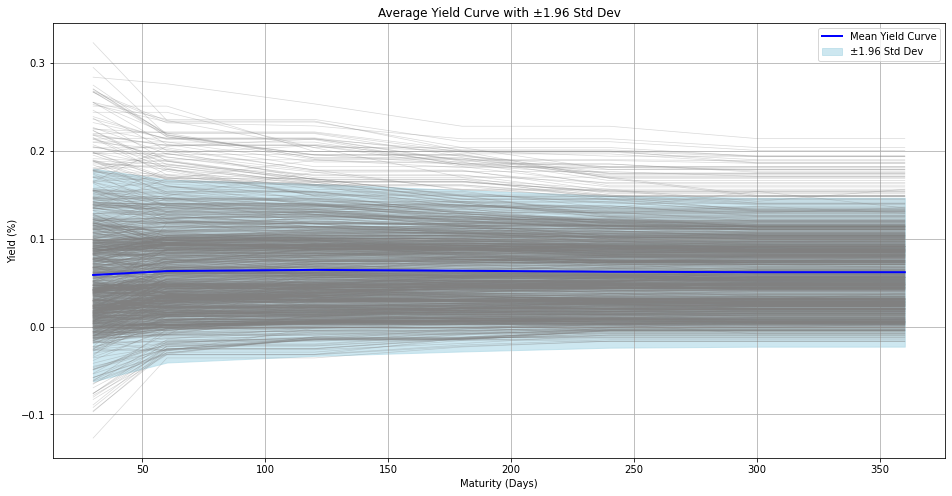

In [169]:
import matplotlib.pyplot as plt

df_data = df_termstructure

mean_yield = df_data.mean(axis=0)
std_yield = df_data.std(axis=0)

std_multiple = 1.96 # 95%

plt.figure(figsize=(16, 8))

for date in df_data.index:
    plt.plot(df_data.loc[date], alpha=0.3, color = 'gray', linewidth=0.7)

plt.plot(mean_yield, color='blue', linewidth=2, label='Mean Yield Curve')
plt.fill_between(term, mean_yield - std_yield * std_multiple, mean_yield + std_yield * std_multiple, color='lightblue', alpha=0.6, label=f'±{std_multiple} Std Dev')

plt.title(f'Average Yield Curve with ±{std_multiple} Std Dev')
plt.xlabel('Maturity (Days)')
plt.ylabel('Yield (%)')
plt.grid(True)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


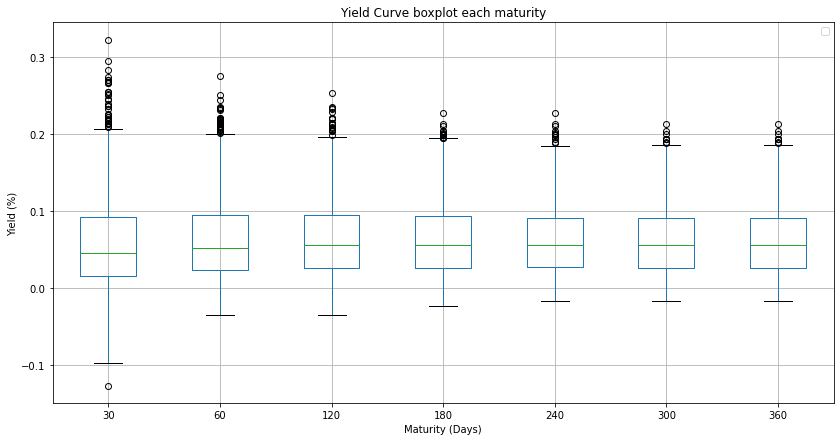

In [170]:
plt.figure(figsize=(14, 7))
df_data.boxplot()

plt.title(f'Yield Curve boxplot each maturity')
plt.xlabel('Maturity (Days)')
plt.ylabel('Yield (%)')
plt.grid(True)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


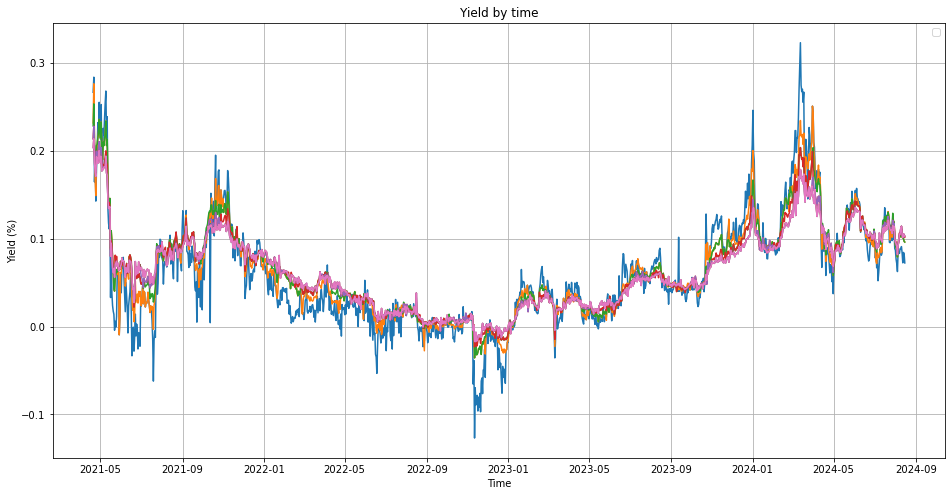

In [175]:
plt.figure(figsize=(16,8))
plt.plot(df_termstructure)

plt.title(f'Yield by time')
plt.xlabel('Time')
plt.ylabel('Yield (%)')
plt.grid(True)
plt.legend()
plt.show()